## Quantum Annealing for the Nuclear Hamiltonian

In [208]:

from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

file_name='data/cki'
SPS=SingleParticleState(file_name=file_name)

[1.63, 2.27]


In [211]:
nparticles_a=4
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

#### Define the initial Hamiltonian

In [212]:

t=3.
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a,size_a))
for i in range(size_a):
    for j in range(size_a):
        (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
        (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
        if np.isclose(mi,-mj) and np.isclose(ni,nj):
            kinetic_term[(i,j)]=t #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=t#np.abs(mi-mj)#+np.abs(ji-jj)
            if size_b==size_a:    
                kinetic_term[(size_a +i,size_a+j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                
external_field=np.zeros(size_a+size_b)
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    external_field[i]=0.
    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

egs,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)
print(egs)

[-36.]


#### Intermediate Hamiltonian

In [194]:
t=-9

IntermediateHamiltonian = FermiHubbardHamiltonian(
    size_a=size_a, size_b=size_b, nparticles_a=nparticles_a, nparticles_b=nparticles_b
)

kinetic_term: Dict = {}
adj_matrix = np.zeros((size_a, size_a))
for i in range(size_a):
    # kinetic_term[(i, (i+1)%size_a)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
    # adj_matrix[i, (i+1)%size_a] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
    
    for j in range(size_a):
        (ni, li, ji, mi, ti, tzi) = SPS.state_encoding[i]
        (nj, lj, jj, mj, tj, tzj) = SPS.state_encoding[j]
        if np.isclose(mi, 1-mj):  # and np.isclose(ji,jj):
            kinetic_term[(i, j)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i, j] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
            if size_a==size_b:
                kinetic_term[(size_a + i, size_a + j)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[i, j] = t  # np.abs(mi-mj)#+np.abs(ji-jj)


external_field = np.zeros(size_a +size_b)
for i in range(size_a +size_b):
    (ni, li, ji, mi, ti, tzi) = SPS.state_encoding[i]
    external_field[i] = ji

    # external_field[i] = SPS.energies[i]

IntermediateHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
#IntermediateHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix_intermediate)
IntermediateHamiltonian.get_hamiltonian()

print(IntermediateHamiltonian.hamiltonian-IntermediateHamiltonian.hamiltonian.conjugate().transpose())
eng, _ = IntermediateHamiltonian.get_spectrum(n_states=1)
print(eng)
print(IntermediateHamiltonian.hamiltonian)


[-61.45584412]
  (0, 2)	-18.0
  (1, 1)	-18.0
  (1, 4)	-18.0
  (2, 0)	-18.0
  (2, 3)	-18.0
  (3, 2)	-18.0
  (4, 1)	-18.0
  (4, 4)	-18.0
  (5, 5)	-18.0
  (5, 8)	-18.0
  (5, 9)	18.0
  (6, 7)	-18.0
  (7, 6)	-18.0
  (7, 12)	-18.0
  (8, 5)	-18.0
  (8, 8)	-18.0
  (8, 13)	-18.0
  (9, 5)	18.0
  (9, 9)	-18.0
  (9, 10)	-18.0
  (9, 13)	18.0
  (10, 9)	-18.0
  (10, 10)	-18.0
  (10, 14)	18.0
  (11, 11)	-36.0
  (12, 7)	-18.0
  (13, 8)	-18.0
  (13, 9)	18.0
  (13, 13)	-18.0
  (13, 14)	-18.0
  (14, 10)	18.0
  (14, 13)	-18.0
  (14, 14)	-18.0


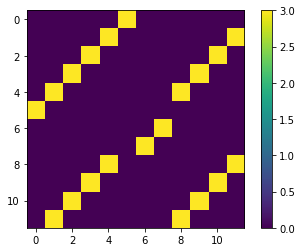

In [183]:
plt.imshow(adj_matrix)
plt.colorbar()
plt.show()

#### Define the target Hamiltonian

In [213]:
twobody_matrix,matrix_j,matrix_m,energies=get_twobody_nuclearshell_model(file_name=file_name)


print(twobody_matrix)

#%% initialize the FH Hamiltonian



   0 1   103 103 103 103    0    3     

     0.0000   -3.1398     0.0000   -6.6779

   -2.7352     0.0000    -0.6490     0.0000

   0 1   103 103 103 101    1    2

    4.0238     0.0000

     0.0000   -2.2055

   0 1   103 103 101 101    0    1

     0.0000    1.0893

   -5.3229     0.0000

   0 1   103 101 103 101    1    2

   -6.5365   -4.2246

     0.8630   -1.1408

   0 1   103 101 101 101    1    1

    1.3920

     0.0000

   0 1   101 101 101 101    0    1

     0.0000   -4.2568

     0.3397     0.0000

-4.0238
0.0
0.0
2.2055
6.5365
0.863
-4.2246
1.1408
[1.63, 2.27]


100%|██████████| 12/12 [00:02<00:00,  4.21it/s]

{(0, 1, 0, 1): -0.6490000000000002, (0, 1, 1, 0): 0.6490000000000002, (1, 0, 0, 1): 0.6490000000000002, (1, 0, 1, 0): -0.6490000000000002, (0, 1, 0, 4): 2.2055000000000007, (0, 1, 4, 0): -2.2055000000000007, (1, 0, 0, 4): -2.2055000000000007, (1, 0, 4, 0): 2.2055000000000007, (0, 2, 0, 2): -0.6490000000000002, (0, 2, 2, 0): 0.6490000000000002, (2, 0, 0, 2): 0.6490000000000002, (2, 0, 2, 0): -0.6490000000000002, (0, 2, 0, 5): 1.1027500000000003, (0, 2, 5, 0): -1.1027500000000003, (2, 0, 0, 5): -1.1027500000000003, (2, 0, 5, 0): 1.1027500000000003, (0, 2, 1, 4): 1.91001902804658, (0, 2, 4, 1): -1.91001902804658, (2, 0, 1, 4): -1.91001902804658, (2, 0, 4, 1): 1.91001902804658, (0, 3, 0, 3): -1.6921, (0, 3, 3, 0): 1.6921, (3, 0, 0, 3): 1.6921, (3, 0, 3, 0): -1.6921, (0, 3, 1, 2): 1.0430999999999995, (0, 3, 2, 1): -1.0430999999999995, (3, 0, 1, 2): -1.0430999999999995, (3, 0, 2, 1): 1.0430999999999995, (0, 3, 1, 5): 1.1027500000000001, (0, 3, 5, 1): -1.1027500000000001, (3, 0, 1, 5): -1.102

In [214]:
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.get_hamiltonian()

egs,psi0=TargetHamiltonian.get_spectrum(n_states=1)

print(egs)

print(TargetHamiltonian.twobody_operator)


Joperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Joperator.get_twobody_interaction(twobody_dict=matrix_j)
Joperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Moperator.get_twobody_interaction(twobody_dict=matrix_m)
Moperator.get_hamiltonian()

size= 12 6
[-30.29539461]
  (0, 0)	-20.565460000000012
  (0, 3)	2.4085009672136346
  (0, 45)	2.4085009672136355
  (0, 48)	-0.6889338110442829
  (1, 1)	-18.249465000000004
  (1, 4)	1.3057509672136356
  (1, 7)	1.9100190280465794
  (1, 15)	-2.315995000000001
  (1, 18)	0.10150048360681718
  (1, 46)	2.307000483606819
  (1, 49)	1.7096958900278656
  (1, 60)	-0.10150048360681718
  (1, 63)	-2.054162795550007
  (1, 105)	0.17580399459982032
  (1, 108)	-0.5966341818903769
  (2, 2)	-17.877325000000003
  (2, 5)	1.043099999999999
  (2, 8)	1.1027499999999997
  (2, 10)	1.1027499999999997
  (2, 14)	-3.7638586855778717
  (2, 16)	-1.2256337924518892
  (2, 19)	0.17580399459981977
  (2, 30)	-1.9530200000000002
  (2, 33)	1.9009985491795476
  (2, 47)	4.106498549179548
  :	:
  (223, 219)	2.205499999999999
  (223, 223)	-12.497387499999997
  (224, 44)	-3.763858685577873
  (224, 58)	-2.3986297010721485
  (224, 71)	0.5966341818903769
  (224, 72)	1.3652289845057242
  (224, 89)	3.763858685577873
  (224, 116)	2.05416

#### Create the interpolate Hamiltonian and Perform the spectrum

100%|██████████| 100/100 [00:00<00:00, 148.22it/s]


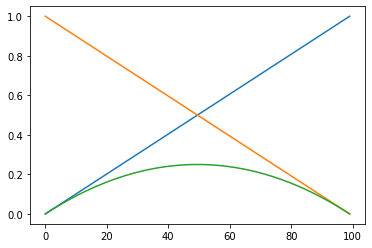

In [215]:
ngrid=100
nlevels=8
lambd=np.linspace(0,1.,ngrid)

spectrum=np.zeros((nlevels,ngrid))
psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
j_values=np.zeros_like(spectrum)
m_values = np.zeros_like(spectrum)

plt.plot(lambd)
plt.plot(1-lambd)
plt.plot(lambd*(1-lambd))

for i in trange(ngrid):

    ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

    values,psis=eigsh(ham,k=8,which='SA')
    for a in range(psis.shape[-1]):    
        j_values[a,i]=psis[:,a].conjugate() @ Joperator.hamiltonian @ psis[:,a]
        m_values[a, i] = psis[:, a].conjugate() @ Moperator.hamiltonian @ psis[:, a]

    spectrum[:,i]=values
    psi_spectrum=psis

Spectrum

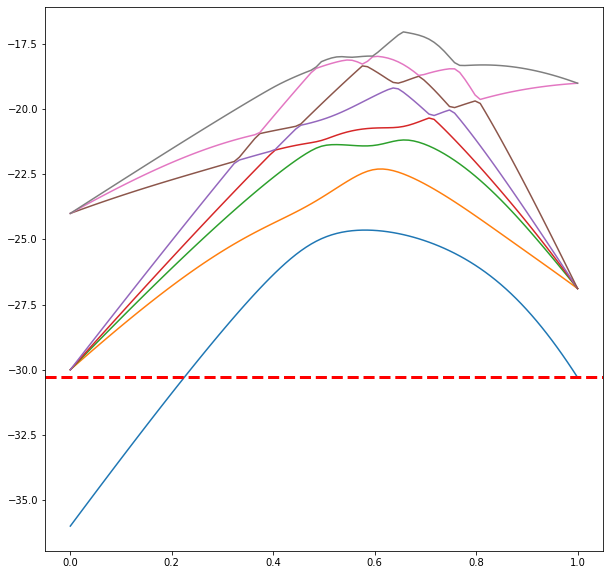

2.3874343004653817
-30.295394613605605


<Figure size 432x288 with 0 Axes>

In [216]:
plt.figure(figsize=(10,10))
for i in range(nlevels):
    plt.plot(lambd,spectrum[i])
# plt.xlim([0.9,1])
plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.show()
plt.savefig('images/be8_spectrum')

t_critic=np.argmax(spectrum[0])
gap=np.min(np.abs(spectrum[1,:]-spectrum[0,:]))
print((gap**2))
print(spectrum[0,-1])

#### Expectation values

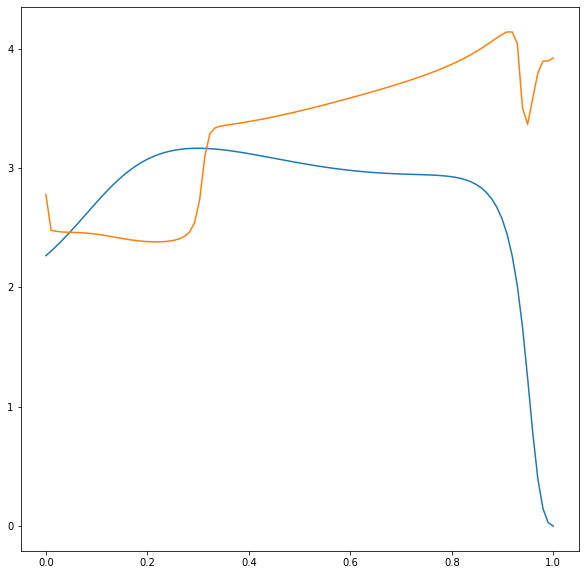

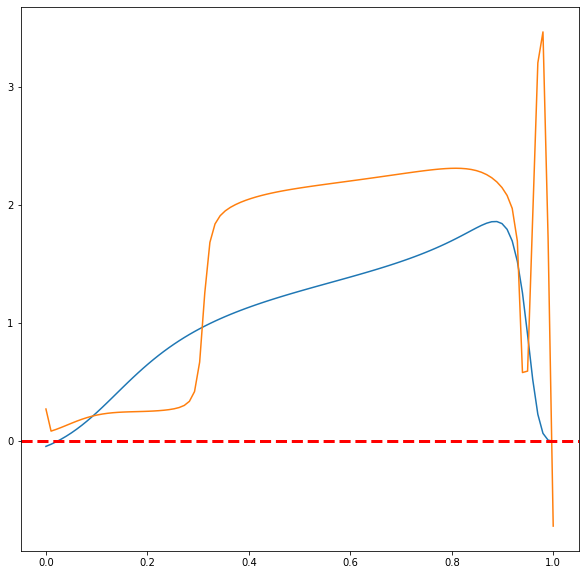

In [179]:
plt.figure(figsize=(10, 10))
for i in range(2):
    plt.plot(lambd, j_values[i])
# plt.xlim([0.9,1])
plt.show()


plt.figure(figsize=(10, 10))
for i in range(2):
    plt.plot(lambd, m_values[i])
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.show()

#### Simulation of the Quantum Annealing

In [217]:
nstep =1000
tf = 30
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=8, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:, 0]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:, 0])
            count=count+1

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)

100%|██████████| 1000/1000 [00:08<00:00, 124.46it/s]

[[0.00037779]]
(0.996884099533384+0j)


(1000, 1, 1)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


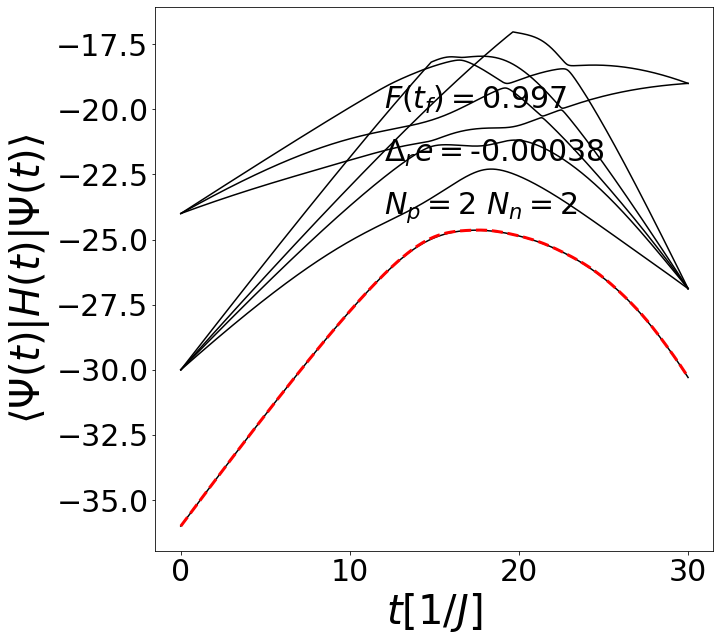

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


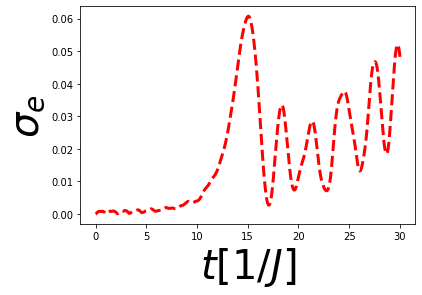

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


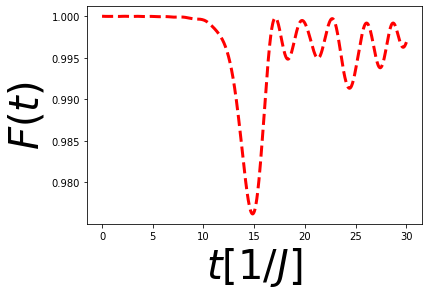

In [218]:
print(eng_t.shape)
plt.figure(figsize=(10, 10))
for i in range(nlevels):
    plt.plot(time, spectrum[i],color='black')


plt.plot(time,eng_t[:,0,0],color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=tf*2/5,y=-20,s=r'$F(t_f)=$'+f'{fidelity.real:.3f}',fontsize=30)
# plt.text(x=tf * 2 / 5, y=-22, s=r"$T_f=$" + f"{tf:.1f} 1/J, h1 strategy", fontsize=30)
plt.text(x=tf * 2 / 5, y=-22, s=r"$\Delta_r e=$" + f"{(eng_t[-1,0,0].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=tf * 2 / 5,
    y=-24,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/be8_qa')
plt.show()


plt.plot(time, variance_t[:, 0, 0], color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$\sigma_e$", fontsize=40)
plt.show()

plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)
plt.savefig('images/be8_fidelity')
plt.show()